# Menu <a class="anchor" id="menu"></a>
   
* [1. Introduction au Topic Modelling](#introduction)
* [2. Analyses Exploratoires des jeux de données](#EDA)
    * [2.1 yelp_academic_dataset_**business**.json](#EDA_business)
    * [2.2 yelp_academic_dataset_**review**.json](#EDA_reviews)
    * [2.3 Préparation du jeu de données de travail](#data_work)
    * [2.4 Analyses du nouveau jeu de données](#multivariate_analysis)
* [3. Prétraitement des données](#pretraitement)
    * [3.1 Tokenization](#tokenize)
    * [3.2 Filtrage des tokens](#filter)
    * [3.3 Lemmatization des tokens](#lemmatize)
    * [3.4 Suppression des mots les plus fréquents](#most_frequents)
    * [3.5 Création du Dictionnaire](#dict)
    * [3.6 Création du Corpus Bag-Of-Words](#corpus_bow)
    * [3.7 Création du Corpus TF-IDF](#corpus_tfidf)
    * [3.8 Création du Corpus Word2Vec](#corpus_word2vec)
* [4. Topic Modelling avec LDA](#lda_topic_modelling)
    * [4.1 Latent Dirichlet Allocation *(LDA)*](#lda)
    * [4.2 Recheche du nombre de sujets avec le score de cohérence](#lda_coherence)
* [5. Topic Modelling avec NMF](#nmf_topic_modelling)
    * [5.1 Negative Matrix Factorisation *(NMF)*](#nmf)
    * [5.2 Recheche du nombre de sujets avec le score de cohérence](#nmf_coherence)
* [6. Choix et entrainement du modèle final](#final_model)
    * [6.1 Entrainement & interprétation du meilleur modèle LDA](#final_model_lda)
        * [Visualisation du modèle LDA](#final_model_lda_vis)
    * [6.2 Entrainement & interprétation du meilleur modèle NMF](#final_model_nmf)
        * [Visualisation du modèle NMF](#final_model_nmf_vis)
    * [6.3 Export du modèle sélectionné](#final_model_export)

---
---
# 1. Introduction au Topic Modelling <a class="anchor" id="introduction"></a> [⇪](#menu)

Un algorithme de topic modelling est un modèle mathématique/statistique utilisé pour déduire quels sont les sujets qui représentent le mieux les données.

Il est basée sur les hypothèses suivantes :
- Un texte (document) est composé de plusieurs sujets.
- Un sujet est composé d'une collection de mots

Le but de l'algorithme est de calculer une *note* de participation à un thème donné pour chaque mot d'un texte, et pour y parvenir nous allons suivre les étapes ci-dessous:

<img src="medias/steps.png" width="700">

- **Step1** : consiste à *récupèrer les données* et à *conduire une Analyse Exploratoire des données*.
- **Step2** : consiste à *tokeniser* les textes *(c'est à dire découper les phrases mot à mot)* et éventuellement à filtrer ces tokens.
- **Step3** : consiste à *créer un dictionnaire associant chaque mot à un ID unique* puis à *créer un corpus des Bag Of Words* représentant la fréquence des tokens dans chaque reviews *(ou un autre corpus du type TF-IDF ou Word2Vec...)*.
- **Step4** : consiste à *construire un modèle permettant d'identifier les sujets* puis à l'ajuster pour *trouver le nombre optimal de sujets*.
- **Step5** : consiste à *utiliser le modèle crée* pour connaitre la distribution des sujets identifiés dans les *(potentiellement nouveaux)* documents.

In [2]:
import os
import sys
import math

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis.gensim_models

import spacy
import spacy_fastlang
from spacy.tokens import DocBin
from collections import Counter
from pprint import pprint
from tqdm import tqdm
# from tqdm.notebook import tqdm

random_seed = 0
np.random.seed(random_seed)

LOAD_TOKENS_FROM_FILE = True
TOKENS_PATH = os.path.join("data", "tokens.bin")

cmap_ref = 'nipy_spectral'


import warnings
warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning) 
# warnings.filterwarnings("ignore", message=".*the imp module is deprecated in favour of importlib;(.|\n)*") # supports regular expressions

---
---
# 2. Analyses Exploratoires <a class="anchor" id="EDA"></a> [⇪](#menu)

Le jeu de données proposé par Yelp propose de nombreux documents, mais tous ne sont pas pertinents pour notre projet...

Nous allons donc nous intéresser aux reviews laissées par les utilisateurs *(yelp_academic_dataset_review.json)* et aux entreprises répertoriées *(yelp_academic_dataset_business.json)*, mais pas aux utilisateurs eux même ou à d'autres informations disponibles dans les autres fichiers.

In [3]:
def get_num_lines(path):
    with open(path) as f:
        for i, _ in enumerate(f):
            pass
    return i+1

## 2.1 `yelp_academic_dataset_business.json` <a class="anchor" id="EDA_business"></a> [⇪](#menu)

En étudiant ce jeu de données, je souhaite découvir si toutes les reviews disponibles sont associées à des entreprises qui correspondent à ce que l'on recherche (des restaurants). Si ce n'est pas le cas, il faudra trouver un moyen d'isoler les reviews qui sont pertinentes pour notre projet.

In [4]:
file_path = os.path.join("data", "yelp_dataset", "yelp_academic_dataset_business.json")
data_business = pd.read_json(file_path, lines=True)  # 150346 x 14
display(data_business.head(2), data_business.shape)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."


(150346, 14)

In [5]:
data_business.categories.value_counts()

Beauty & Spas, Nail Salons                                                                                       1012
Restaurants, Pizza                                                                                                935
Nail Salons, Beauty & Spas                                                                                        934
Pizza, Restaurants                                                                                                823
Restaurants, Mexican                                                                                              728
                                                                                                                 ... 
Dermatologists, Health & Medical, Cosmetic Surgeons, Doctors, Acne Treatment, Skin Care, Beauty & Spas              1
Home Services, Home & Garden, Nurseries & Gardening, Hardware Stores, Shopping, Building Supplies, Appliances       1
Food Trucks, Smokehouse, Restaurants, Food, Barbeque, So

In [6]:
data_business.categories.str.contains('Restaurant').value_counts(dropna=False)

False    97957
True     52286
None       103
Name: categories, dtype: int64

>#### Il y a visiblement beaucoup de commerces qui ne sont pas des restaurants... on va donc devoir trouver un moyen d'isoler les reviews qui concernent les restaurants.

### Préparation d'un jeu de données regroupants les business qui sont des restaurants

In [7]:
data_restaurant = data_business[data_business.categories.str.contains("Restaurant") == True]
display(data_restaurant.head(2), data_restaurant.shape)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '..."


(52286, 14)

### Supprimons ceux qui font également Hotel car c'est un thème assez fort qui risque de prendre le pas sur la Restauration

In [8]:
data_restaurant = data_restaurant[data_restaurant.categories.str.contains("Hotel") == False]
display(data_restaurant.head(2), data_restaurant.shape)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '..."


(51864, 14)

---
>#### `TODO`  done ✅ | todo ❌ |
> - ✅ Il faut filtrer les reviews en utilisant data_restaurant pour ne conserver que celles qui sont liés à la restauration *(qui est notre sujet)*
<br><u>*(action: fait ci-dessous)*</u>

## 2.2 `yelp_academic_dataset_review.json` <a class="anchor" id="EDA_reviews"></a> [⇪](#menu)
En étudiant ce jeu de données, je souhaite découvrir un moyen de séparer les commentaires positifs des commentaires négatifs *(qui sont ceux qui nous intéressent pour pouvoir identifier les sujets d'insatisfaction)*

In [9]:
file_path = os.path.join("data", "yelp_dataset", "yelp_academic_dataset_review.json")
data_review = pd.read_json(file_path, lines=True, nrows=1000000)  # 6990280 x 9
display(data_review.head(2), data_review.shape)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18


(1000000, 9)

In [10]:
(get_num_lines(file_path), data_review.shape[1])

(6990280, 9)

### Regardons plus en détails les variables du jeu de données

#### Les variables qualitatives

In [11]:
data_review.describe(exclude=['number','datetime']).T

,count,unique,top,freq
review_id,1000000,1000000,KU_O5udG6zpxOg-VcAEodg,1
user_id,1000000,542003,_BcWyKQL16ndpBdggh2kNA,483
business_id,1000000,27095,GBTPC53ZrG1ZBY3DT8Mbcw,4661
text,1000000,998357,I have eaten at just about every decent Indian...,5


#### Les variables quantitatives

In [12]:
data_review.describe(datetime_is_numeric=True).T

,count,mean,min,25%,50%,75%,max,std
stars,1000000.0,3.783959,1.0,3.0,4.0,5.0,5.0,1.440197
useful,1000000.0,1.106594,0.0,0.0,0.0,1.0,539.0,2.848906
funny,1000000.0,0.307812,0.0,0.0,0.0,0.0,284.0,1.428185
cool,1000000.0,0.457129,0.0,0.0,0.0,0.0,172.0,1.799114
date,1000000,2016-07-13 10:09:02.464016128,2005-03-01 17:47:15,2014-08-07 16:29:16.500000,2016-10-11 16:02:42,2018-09-01 01:26:22.249999872,2022-01-19 19:47:59,NaN


>#### Le meilleur moyen de séparer les bons des mauvais commentaires semble donc être de s'appuyer sur la colonne `stars`.
> Nous pourrions binariser les reviews en associant les notes inférieures à 2.5 à une mauvaise review et celles supérieures à 2.5 à une bonne review.<br>Mais pour éviter les commentaires trop neutres entre les deux, on ne va garder que les notes de 1 et 2 comme indicateur d'insatisfaction.

---
>#### `TODO`  done ✅ | todo ❌ |
> - ✅ Il faut binariser les reviews pour ne garder que les mots liés à l'instatisfaction.
<br><u>*(action: fait en fin de partie 2.4)*</u>

## 2.3 Préparation du jeu de données de travail <a class="anchor" id="data_work"></a> [⇪](#menu)

### Supprimons les reviews qui ne concernent pas des restaurants et gardons uniquement les colonnes utiles pour la suite

In [13]:
join_restaurant_reviews = data_review.merge(data_restaurant, on='business_id', how='left')

In [14]:
join_restaurant_reviews.categories.value_counts(dropna=False)

NaN                                                                                                                                   322628
Restaurants, Mexican                                                                                                                    7915
Mexican, Restaurants                                                                                                                    6219
Restaurants, Pizza                                                                                                                      4760
German, Restaurants, Seafood, Cocktail Bars, French, Brasseries, American (New), Nightlife, Bars, Cajun/Creole, Breakfast & Brunch      4661
                                                                                                                                       ...  
Imported Food, Restaurants, Mexican, Breakfast & Brunch, Food, Specialty Food, Ethnic Food                                                 1
Cafes, Coffee

In [15]:
data_review_restos = join_restaurant_reviews[['stars_x', 'text', 'user_id', 'business_id', 'review_id']][join_restaurant_reviews.categories.notnull()]
data_review_restos.rename(columns={'stars_x':'stars'}, inplace=True)
display(data_review_restos.head(2), data_review_restos.shape)

,stars,text,user_id,business_id,review_id
0,3,"If you decide to eat here, just be aware it is...",mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,KU_O5udG6zpxOg-VcAEodg
2,3,Family diner. Had the buffet. Eclectic assortm...,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,saUsX_uimxRlCVr67Z4Jig


(677372, 5)

### Supprimons les éventuels reviews sans texte

In [16]:
data_review_restos.text.isnull().sum()

0

>#### Il n'y a donc pas de reviews sans texte (comme nous l'avions déjà vu avec les describes)

### Supprimons les éventuels doublons

#### Vérifions tout d'abord si l'on a des doublons sur la base des colonnes que nous avons gardés

In [17]:
data_review_restos.duplicated().sum()

0

>#### Il n'y a donc pas de doublons si l'on garde toutes les colonnes

#### Mais il se pourrait que chaque review ait bien un ID unique alors que l'on a plusieurs fois les mêmes textes par un même client sur le même restaurant...

In [18]:
subset = ['stars', 'text', 'user_id', 'business_id']
data_review_restos.duplicated(subset=subset).sum()

987

#### Comparons quelque uns de ces duplicatas pour vérifier...

In [19]:
data_review_restos[data_review_restos.duplicated(subset=subset, keep='first')].sort_values('text').head()

,stars,text,user_id,business_id,review_id
586767,5,"""Prep's Breakfast Sammie"" is the BEST breakfas...",Xf5hPJl9P4r9rRAy-NR46g,UCMSWPqzXjd7QHq7v8PJjQ,Oz8E7WQ5JVlrCC6-PGdY8Q
416542,2,"""We ran out of bread"" they said, as we drove o...",oUzXQqxXkFGL5k1OEmFr4g,34Eqv8jXgxg_EEwcsNgeeg,CF4rf7--EneYMVHAPgX7Jg
460249,1,"""Who's in the kitchen and why can't they do th...",CL5U0V87_Ord4cp9pE40Pw,XQfwVwDr-v0ZS3_CbbE5Xw,PnqDAlcL2-S9oOgn34Lzkw
202235,2,2 stars for cheap drinks. I was happy to see t...,ce9ZWyllsjOGHtdu6NpZww,4yKv0SEpuJDHECFinhifWQ,r_FsYzzKJG4wCgebF7e_sQ
684442,1,20 minutes and no server. Owner finally took a...,dTY6QRU-ox_HqX1A7I88tw,Ea2hPSFazxXITET4f6ZJhw,VNMwljSo3CGUwdiUQSukPg


In [20]:
data_review_restos[data_review_restos.duplicated(subset=subset, keep='last')].sort_values('text').head()

,stars,text,user_id,business_id,review_id
498137,5,"""Prep's Breakfast Sammie"" is the BEST breakfas...",Xf5hPJl9P4r9rRAy-NR46g,UCMSWPqzXjd7QHq7v8PJjQ,uZ0nZRQ-RpttoLCym2DyHw
322765,2,"""We ran out of bread"" they said, as we drove o...",oUzXQqxXkFGL5k1OEmFr4g,34Eqv8jXgxg_EEwcsNgeeg,mSKC9E97PpwdB3L3Jnxc2A
60045,1,"""Who's in the kitchen and why can't they do th...",CL5U0V87_Ord4cp9pE40Pw,XQfwVwDr-v0ZS3_CbbE5Xw,241ycTAVakh4sY8b7S_jyQ
134308,2,2 stars for cheap drinks. I was happy to see t...,ce9ZWyllsjOGHtdu6NpZww,4yKv0SEpuJDHECFinhifWQ,z2Cl4obOdxpC1uDnnsdnQw
371454,1,20 minutes and no server. Owner finally took a...,dTY6QRU-ox_HqX1A7I88tw,Ea2hPSFazxXITET4f6ZJhw,SdHOvSqwRRZHaX-ON8QEmw


#### On a effectivement quelques doublons qu'il vaudrait mieux nettoyer pour éviter de mettre plus de poids sur certains mots

In [21]:
print("AVANT:", data_review_restos.shape)
data_review_restos.drop_duplicates(subset=subset, inplace=True)
print("APRÈS:", data_review_restos.shape)

AVANT: (677372, 5)
APRÈS: (676385, 5)


#### Enfin supprimons les colonnes qui ne servaient qu'à vérifier la présence de doublons

In [22]:
data_review_restos = data_review_restos[['stars', 'text']]

## 2.4 Analyses du nouveau jeu de données <a class="anchor" id="multivariate_analysis"></a> [⇪](#menu)

#### Les variables qualitatives

In [23]:
data_review_restos.describe(exclude=['number','datetime']).T

,count,unique,top,freq
text,676385,676228,"At the height of the Omicron surge, Wendy's DO...",4


#### Les variables quantitatives

In [24]:
data_review_restos.describe(datetime_is_numeric=True).T

,count,mean,std,min,25%,50%,75%,max
stars,676385.0,3.807592,1.366187,1.0,3.0,4.0,5.0,5.0


### Répartition de la taille des reviews

In [25]:
def plot_review_sizes(data):
    select = pd.DataFrame(data.review_size.value_counts()).reset_index()
    select.sort_values(by='index', inplace=True)
    select.set_index('index', inplace=True)

    review_size_mean = data.review_size.mean()
    review_size_median = data.review_size.median()

    fig = plt.figure(figsize=(15, 7))
    plt.subplot(2,2,1)
    sns.lineplot(data=select, y='review_size', x='index')
    plt.plot([review_size_mean,review_size_mean],[0,10000], label=f"Moyenne ({review_size_mean:.2f})", alpha=0.5)
    plt.plot([review_size_median,review_size_median],[0,10000], label=f"Médiane ({review_size_median:.2f})", alpha=0.5)
    plt.title("Répartition des reviews en fonction du nombre de mots")
    plt.xlabel("Nombre de mots")
    plt.ylabel("Nombre de reviews")
    #plt.ylim(0,10000)
    plt.legend()

    plt.subplot(2,2,2)
    zoom_left, zoom_right = 0, 150
    sns.lineplot(data=select[zoom_left:zoom_right], y='review_size', x='index')
    plt.plot([review_size_mean,review_size_mean],[0,10000], label=f"Moyenne ({review_size_mean:.2f})", alpha=0.5)
    plt.plot([review_size_median,review_size_median],[0,10000], label=f"Médiane ({review_size_median:.2f})", alpha=0.5)
    plt.title(f"Répartition des reviews en fonction du nombre de mots (zoom {zoom_left} à {zoom_right} mots)")
    plt.xlabel("Nombre de mots")
    plt.ylabel("Nombre de reviews")
    #plt.ylim(0,10000)
    plt.legend()

    select2 = np.cumsum(select)

    plt.subplot(2,2,3)
    sns.lineplot(data=select2, y='review_size', x='index')
    #plt.plot([xxx,xxx],[0,10000], label="Moyenne", alpha=0.5)
    plt.title("Répartition cumulée des reviews en fonction du nombre de mots")
    plt.xlabel("Nombre de mots")
    plt.ylabel("Nombre de reviews")

    plt.subplot(2,2,4)
    zoom_left, zoom_right = 0, 20
    sns.lineplot(data=select2[zoom_left:zoom_right], y='review_size', x='index')
    plt.title(f"Répartition cumulée des reviews en fonction du nombre de mots (zoom {zoom_left} à {zoom_right} mots)")
    plt.xlabel("Nombre de mots")
    plt.ylabel("Nombre de reviews")

    plt.tight_layout()
    plt.show()

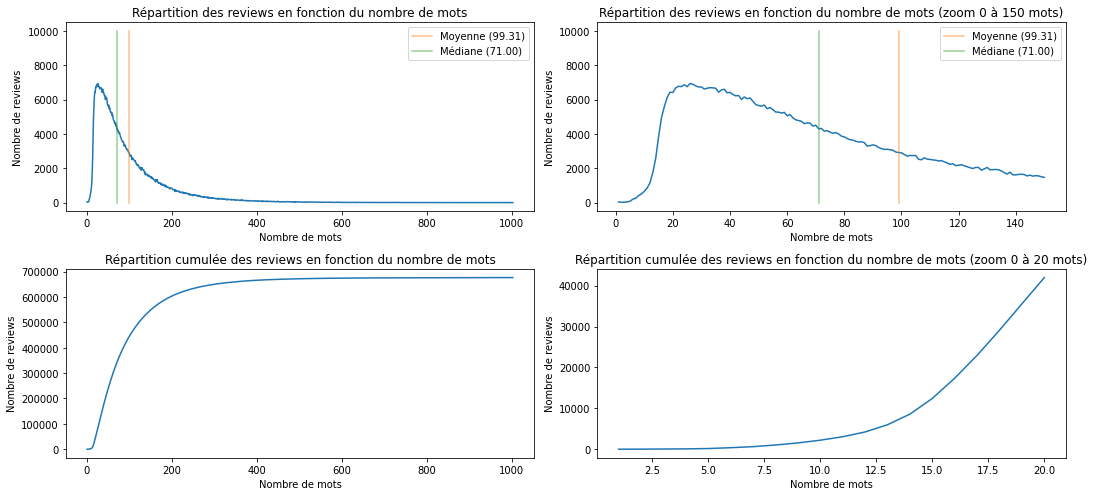

In [26]:
data_tmp = data_review_restos.copy()
data_tmp['review_size'] = data_review_restos.text.apply(lambda x: len(x.split()))
plot_review_sizes(data_tmp)

In [27]:
data_tmp.review_size.describe()

count    676385.000000
mean         99.309070
std          91.630058
min           1.000000
25%          39.000000
50%          71.000000
75%         127.000000
max        1003.000000
Name: review_size, dtype: float64

In [28]:
data_tmp[ data_tmp.review_size > 457 ].shape

(6530, 3)

>#### On constate que :
> - la moitié des reviews ont moins de 75 "mots"
> - 48 des 1.000.000 de reviews ont 1 "mot"...
> - 275 des 1.000.000 de reviews ont 5 "mots" ou moins.
> - environ 800.000 des 1.000.000 de reviews ont moins de 150 "mots"

---
>#### `TODO`  done ✅ | todo ❌ |
> - ✅ Il faut supprimer les outliers. Ils risquent d'utiliser des mots non réprésentatifs.
<br><u>*(action: fait ci-dessous)*</u>

#### Supprimons les outliers avec trop de textes et qui risquent donc d'utiliser des mots non représentatifs

In [29]:
data_clean = data_tmp[ data_tmp.review_size < data_tmp.review_size.quantile(0.99)]
display(data_clean.head(2), data_clean.shape)

,stars,text,review_size
0,3,"If you decide to eat here, just be aware it is...",101
2,3,Family diner. Had the buffet. Eclectic assortm...,55


(669615, 3)

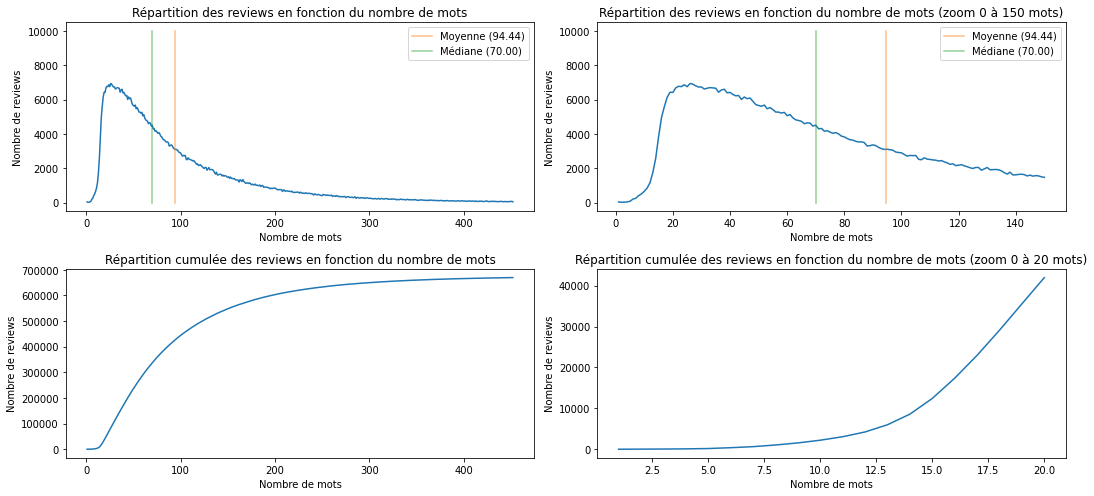

In [30]:
data_tmp = data_clean.copy()
data_tmp['review_size'] = data_clean.text.apply(lambda x: len(x.split()))
plot_review_sizes(data_tmp)

### Explorons un peu les textes qui n'ont été découpés qu'en un seul "mot"

In [31]:
print(data_clean.text[ data_clean.review_size == 1 ][:20])

27539                                                   Boo
67931     意餐，营业到晚上10点，mix的加州红酒很好，这里有意大利和加州的葡萄酒，牛排稍微过熟了，人...
69333                                               Awesome
142373    太美味！连续吃了两个晚上，是在美国少有的鲜美，而环境又非常不错。昨天的担担面、香菇青菜都很好...
144918                                           C'mon!!!!!
183565                                                  Lll
184566                                                  Wow
259830    招牌沙拉就是生菜叶拌咸味沙拉酱，星期四特供的炒饭就是剩饭炒饭，绿洋葱香肠的味道实在不敢恭维，...
265618                                                    .
267429    ダウンタウンの外れにある静かなレストラン。ディナーを食べに行ったが、オシャレな空間の割に静か...
352724                                                 Booo
423441    http://keepbusylife.blogspot.com/2015/03/chees...
442880    点了三杯鸡，酸菜汤，滑蛋虾仁，卤肉饭。都比较一般。达不到惊喜，一般都比较困难，可能还达不到一...
454874    服務唔錯啦，但係嘢食其實冇expect咁好食，點咗牛肉烏東同埋芝士咖喱牛肉烏冬，牛肉新鮮嘅程...
458605    村里新开的川菜馆，味道很好，和国内比都毫不逊色，我最爱他家的烤鱼、哑巴兔和冒菜，适合喜欢吃辣...
468655                                                 Nice
472524    我每次來費城都是為了辦展，這裡的展館對華人來講很方便，旁邊就

>#### On constate que:
> - il y a de nombreux textes qui ne sont pas en Anglais...
> - il y a des url seules
> - il y a des smileys seuls
> - il y a des mots seuls

---
>#### `TODO`  done ✅ | todo ❌ |
> - ✅ Il faut faire en sorte de ne garder que les textes en Anglais.
<br><u>*(action: fait juste après la tokenization)*</u>
> - ❌ Il faut supprimer les entrées avec des URL seules.
> - ✅ Il faut supprimer les reviews d'un seul mot *(elles ne sont que 48 sur 1 millions si l'on compte les langues asiatiques mal splittées)*.
<br><u>*(action: fait ci-dessous)*</u>

#### Supprimons les outliers avec trop peu de textes

In [32]:
data_clean = data_clean[ data_clean.review_size > 1 ][['stars','text']]
display(data_clean.head(2), data_clean.shape)

,stars,text
0,3,"If you decide to eat here, just be aware it is..."
2,3,Family diner. Had the buffet. Eclectic assortm...


(669575, 2)

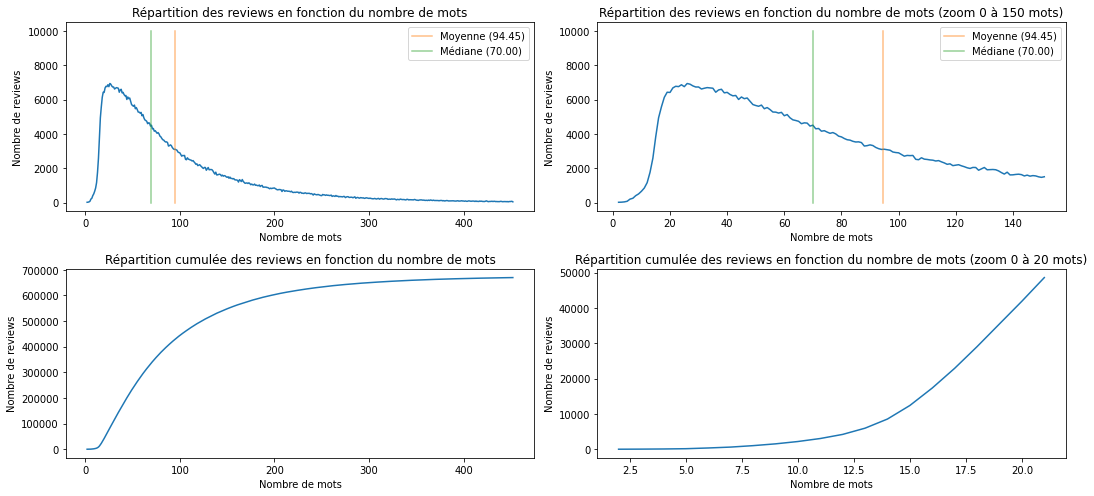

In [33]:
data_tmp = data_clean.copy()
data_tmp['review_size'] = data_clean.text.apply(lambda x: len(x.split()))
plot_review_sizes(data_tmp)

### Répartition des notes *(stars)* des reviews

In [34]:
def plot_bars(data_, title, labels_modulo=1, labels_rotation=90, show_values=True, show_percent=False, x_label=None, y_label=None, **args):
    
    if show_percent:
        total = data_.values.sum()
        data_ = round(data_/total*100.0,2)
        
    fig = plt.figure(figsize=(15, 4))
        
    #with plt.rc_context({
    #    'axes.edgecolor':'orange',
    #    'xtick.color':'orange', 
    #    'ytick.color':'orange', 
    #    'text.color': 'orange',
    #    'axes.labelcolor': 'orange',
        #'figure.facecolor':'orange'
    #}):

    ax = sns.barplot(data=data_, **args)

    if show_values:
        ax.bar_label(ax.containers[0])

    new_ticks = [i.get_text() for i in ax.get_xticklabels()]
    plt.xticks(range(0, len(new_ticks), labels_modulo), new_ticks[::labels_modulo], rotation=labels_rotation)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    plt.show()

    #fig.savefig(f"medias/export.png", transparent=True)

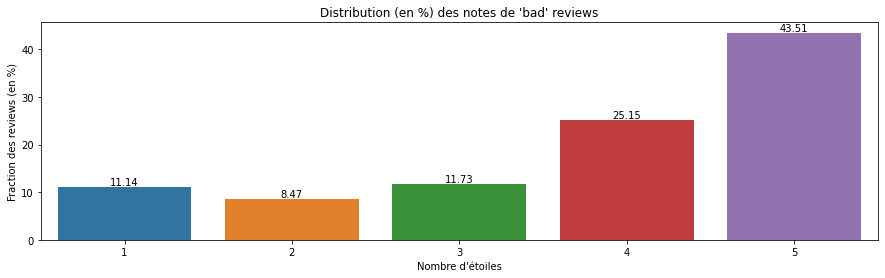

In [35]:
select = pd.DataFrame(data_clean.stars.value_counts()).reset_index()
select.sort_values(by='index', inplace=True)
select.set_index('index', inplace=True)

plot_bars(select.T, "Distribution (en %) des notes de 'bad' reviews", y_label="Fraction des reviews (en %)", x_label="Nombre d'étoiles", labels_rotation=0, show_percent=True)

>#### Nous constatons que la majorité des clients semblent satisfaits.
> Mais dans le cadre de notre projets nous voulons surtout identifier *les sujets qui préoccupent les personnes ayant laissé une mauvaise note*.<br>
> Nous allons donc travailler sur un échantillon de reviews dont les notes sont de 1 ou 2.

#### Binarisation du jeu de données

In [36]:
data_clean['is_low'] = data_clean.stars <= 2 # TRUE with 1,2 stars and FALSE with 3,4,5 stars
display(data_clean.head(2), data_clean.shape)

,stars,text,is_low
0,3,"If you decide to eat here, just be aware it is...",False
2,3,Family diner. Had the buffet. Eclectic assortm...,False


(669575, 3)

In [37]:
data_clean[data_clean.is_low].shape

(131323, 3)

>#### On a donc environ 216k "mauvaises" reviews à utiliser *(en ayant limité le nombre initial de reviews chargées à 1000k)*

#### Sélection au hasard des "mauvaises" reviews *(en conservant le ratio initial des notes)*

In [38]:
sample_size = 10000

In [39]:
# Select samples with the original dataset stars' ratio
data_bad_reviews = data_clean[data_clean.is_low == True].sample(sample_size, random_state=random_seed)[['stars', 'text']].reset_index(drop=True)
display(data_bad_reviews.head(2), data_bad_reviews.shape)

,stars,text
0,2,Went on a Saturday afternoon for lunch with a ...
1,2,"We tried this place twice. Seating was slow, s..."


(10000, 2)

#### Affichage de la distribution des scores dans le nouveau dataset

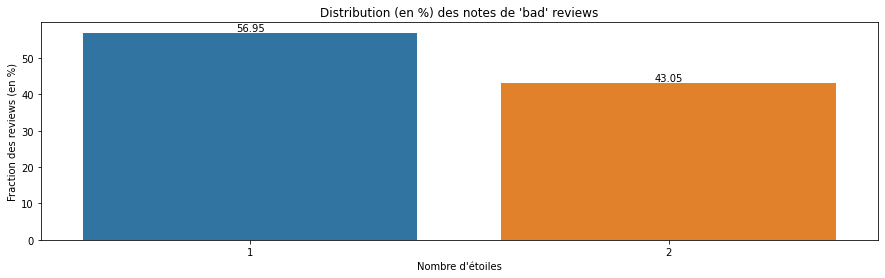

In [40]:
select = pd.DataFrame(data_bad_reviews.stars.value_counts()).reset_index()
select.sort_values(by='index', inplace=True)
select.set_index('index', inplace=True)

plot_bars(select.T, "Distribution (en %) des notes de 'bad' reviews", y_label="Fraction des reviews (en %)", x_label="Nombre d'étoiles", labels_rotation=0, show_percent=True)

---
---
# 3. Prétraitement des données <a class="anchor" id="pretraitement"></a> [⇪](#menu)

Nous allons utiliser pour préparer les données à l'analyse, une bibliothèque open-source appelée [spaCy](http://spacy.io), mais d'autres bibliothèques telles que [NLTK](https://www.nltk.org) peuvent également être utilisées.

Au cours du processus de Tokenisation, *spaCy* va ajouter plusieurs informations au document, que nous pourrons utiliser ultérieurement *(comme le type, le lemme, etc.)*

<img src="medias/tokenize.png" width="500">

#### Visualisons le jeu de données avant la tokenisation

In [41]:
from wordcloud import WordCloud

In [42]:
from PIL import Image

In [43]:
def plot_wordcloud(text, from_frequency=False, name="wordcloud"):
    alice_mask = np.array(Image.open("medias/plate_shape.jpg"))
    
    # Create the wordcloud object (the size depends on the mask...)
    wordcloud_export = WordCloud(background_color=None, mode="RGBA", width=1000, height=700, margin=2, collocations=False, random_state=random_seed, mask=alice_mask)
    wordcloud_clean = WordCloud(background_color="White", mode="RGB", width=1000, height=700, margin=2, collocations=False, random_state=random_seed, mask=alice_mask)
    
    if from_frequency:
        wordcloud_export = wordcloud_export.generate_from_frequencies(text)
        wordcloud_clean = wordcloud_clean.generate_from_frequencies(text)
    else:
        wordcloud_export = wordcloud_export.generate(text)
        wordcloud_clean = wordcloud_clean.generate(text)

    # Display the generated image:
    fig = plt.figure(figsize=(15, 10.5))
    plt.imshow(wordcloud_clean, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()
    
    # Export
    wordcloud_export.to_file(f"medias/{name}.png")
    
    #fig.savefig(f"medias/{name}.png", transparent=True)

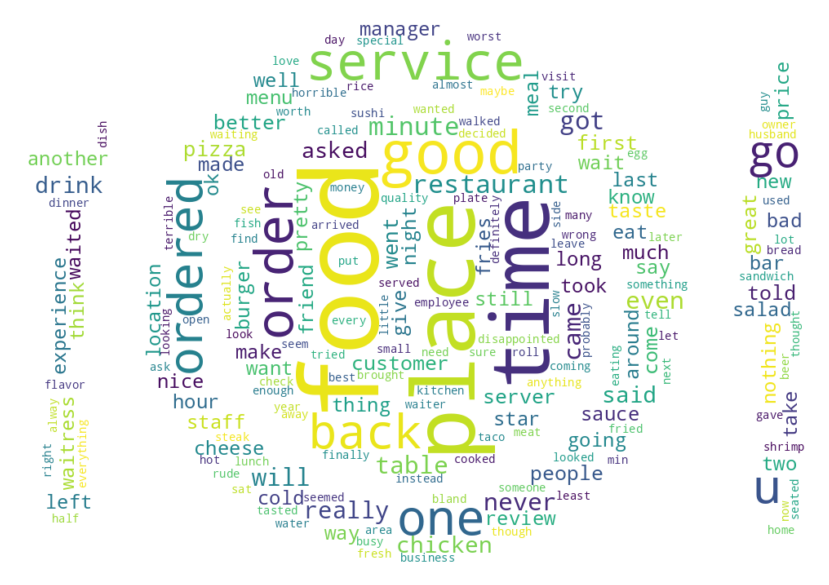

In [44]:
plot_wordcloud(" ".join([x for x in data_bad_reviews.text]), name="wordcloud1")

## 3.1 Tokenization <a class="anchor" id="tokenize"></a> [⇪](#menu)
>#### Nous allons profiter de cette étape de tokenisation pour supprimer:
> - les majuscules,
> - les espaces en début et fin de texte.

In [45]:
!python -m spacy download en_core_web_sm -qq
#!python -m spacy download en_core_web_md -qq
nlp = spacy.load('en_core_web_sm')

2022-07-11 17:07:08.129130: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-11 17:07:08.129165: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [46]:
nlp.add_pipe("language_detector")

In [47]:
def tokenize(text):

    # suppression des majuscules
    text = text.lower()

    # suppression des espaces au début et à la fin des textes
    text = text.strip()

    # tokenisation
    return nlp(text)

In [48]:
display(data_bad_reviews.head(2), data_bad_reviews.shape)

,stars,text
0,2,Went on a Saturday afternoon for lunch with a ...
1,2,"We tried this place twice. Seating was slow, s..."


(10000, 2)

### Préparons les Tokens *(ou chargeons les si ils ont déjà été sauvegardés)*

In [49]:
def save_tokens(data, path):
    #doc_bin = DocBin(attrs=["LEMMA", "ENT_IOB", "ENT_TYPE"], store_user_data=True)
    doc_bin = DocBin(store_user_data=True)
    data.apply(lambda x: doc_bin.add(x))
    bytes_data = doc_bin.to_bytes()
    
    with open(path, "wb") as binary_file:
        binary_file.write(bytes_data)
        
def load_tokens(path):
    with open(path, "rb") as binary_file:
        bytes_data = binary_file.read()
        
    nlp = spacy.blank("en")
    doc_bin = DocBin().from_bytes(bytes_data)
    docs = list(doc_bin.get_docs(nlp.vocab))
    
    return docs

In [50]:
if(os.path.exists(TOKENS_PATH) and LOAD_TOKENS_FROM_FILE==True):
    print(f"LOADING Tokens from '{TOKENS_PATH}'")
    data_bad_reviews['spacy_doc'] = load_tokens(TOKENS_PATH)
else:
    print(f"PREPARING Tokens")
    data_bad_reviews['spacy_doc'] = data_bad_reviews.text.apply(tokenize)
    print(f"SAVING Tokens tp '{TOKENS_PATH}'")
    save_tokens(data_bad_reviews['spacy_doc'], TOKENS_PATH)

LOADING Tokens from 'data/tokens.bin'


In [51]:
display(data_bad_reviews.head(2), data_bad_reviews.shape)

,stars,text,spacy_doc
0,2,Went on a Saturday afternoon for lunch with a ...,"(went, on, a, saturday, afternoon, for, lunch,..."
1,2,"We tried this place twice. Seating was slow, s...","(we, tried, this, place, twice, ., seating, wa..."


(10000, 3)

## 3.2 Filtrage des tokens <a class="anchor" id="filter"></a> [⇪](#menu)

>#### Nous allons profiter de cette étape pour supprimer:
> - ~~les majuscules~~ *(fait lors de la tokenization)*,
> - ~~les espaces en début et fin de texte.~~ *(fait lors de la tokenization)*,
> - tout ce qui n'est pas détecté comme étant de l'anglais *(language & language_score)*,
> - la ponctuation *(PUNCT)*,
> - les stop-words *(is_stop)*,
> - les espaces *(SPACE)*,
> - les chiffres *(is_alpha)*,
> - mais aussi les beaucoup d'autres tags peu utiles dans ce cas *(ADV, AUX, CONJ, CCONJ, DET, PART, PRON, PROPN, SCONJ, SYM)*.
>
>#### Par ailleurs on va utiliser les **lemmes** *(raçines contextualisées)* des mots pour rassembler ceux qui sont assez similaires.

> pos_ tag ist
>
> - `ADJ`: adjective, e.g. big, old, green, incomprehensible, first
> - `ADP`: adposition, e.g. in, to, during
> - `ADV`: adverb, e.g. very, tomorrow, down, where, there
> - `AUX`: auxiliary, e.g. is, has (done), will (do), should (do)
> - `CONJ`: conjunction, e.g. and, or, but
> - `CCONJ`: coordinating conjunction, e.g. and, or, but
> - `DET`: determiner, e.g. a, an, the
> - `INTJ`: interjection, e.g. psst, ouch, bravo, hello
> - `NOUN`: noun, e.g. girl, cat, tree, air, beauty
> - `NUM`: numeral, e.g. 1, 2017, one, seventy-seven, IV, MMXIV
> - `PART`: particle, e.g. ’s, not,
> - `PRON`: pronoun, e.g I, you, he, she, myself, themselves, somebody
> - `PROPN`: proper noun, e.g. Mary, John, London, NATO, HBO
> - `PUNCT`: punctuation, e.g. ., (, ), ?
> - `SCONJ`: subordinating conjunction, e.g. if, while, that
> - `SYM`: symbol, e.g. $, %, §, ©, +, −, ×, ÷, =, :), 😝
> - `VERB`: verb, e.g. run, runs, running, eat, ate, eating
> - `X`: other, e.g. sfpksdpsxmsa
> - `SPACE`: space, e.g. 

In [52]:
def filter_tokens(doc, except_words = []):

    # suppression des majuscules
    # text = text_.lower()

    # suppression des espaces au début et à la fin des textes
    #text = text.strip()

    # tokenisation
    # doc = nlp(text)
    # spacy.displacy.render(doc, style='dep',jupyter=True)
    
    # suppression des stopwords, de la ponctuation, des espaces et des adverbes et de ce qui n'est pas en anglais
    tokens = [token for token in doc 
              if not token.is_stop 
              and doc._.language == 'en'
              and doc._.language_score > 0.7
              #and not token.is_punct
              #and not token.is_space 
              #and not token.is_digit 
              and token.is_alpha
              and token.pos_ not in ['ADV', 'AUX', 'CONJ', 'CCONJ', 'DET', 'PART', 'PRON', 'PROPN', 'PUNCT', 'SCONJ', 'SPACE', 'SYM'] 
              and token.lemma_ not in except_words
             ]
        
    return tokens if len(tokens) > 1 else "FILTERED"

#### Regardons si il y a des textes dans d'autres langues ou dans de l'anglais approximatif ou argotique

In [53]:
for doc in data_bad_reviews.spacy_doc:
    # is in english
    if doc._.language != 'en':
        print("NOT ENGLISH:\n", doc, "\n", "-"*50)
    elif doc._.language_score <= 0.7:
        print(f"GIBBERISH:{doc._.language_score}\n", doc, "\n", "-"*50)

GIBBERISH:0.4564344882965088
 good grilled chicken sandwich.  bland fries. 
 --------------------------------------------------
NOT ENGLISH:
 値段も高く、お味も普通。観光客向けのシーフードレストラン。。ワイングラスで提供されないワインを初めてみました。
店内はカウンター席しかありませんでした。気候が良ければ外のテーブルの方が気持ち良さそうです。 
 --------------------------------------------------
NOT ENGLISH:
 no es buena, la pizza es tarta de culo y huele a tripa de pescado 
 --------------------------------------------------
NOT ENGLISH:
 fui con unos amigos a este lugar súper recomendado y nuestra experiencia fue pésima. lo que vas a ver en el menú son todo tapas a precios de platos principales.  ojo ok son platicos mínimos para picar. un amigo le llego primero su plato y a los 15 min llego el resto. el servicio mediocre. pero lo peor la música una tipa con voz que solo me agradaba cuando se callaba. por favor si van entrar miren primero quien esta tocando la música y después decidan si quedarse. 
 --------------------------------------------------
GIBBERISH:0.6255496144294739
 thir

>#### On découvre:
> - plusieurs textes en espagnol ou en japonais/chinois
> - un casier judiciaire
> - des textes rédigés en plusieurs langues

---
>#### `TODO`  done ✅ | todo ❌ |
> - ✅ Suppression des langues étrangères *(ce qui n'est pas de l'Anglais)*
<br><u>*(action: fait ci-dessous avec la function filter_tokens)*</u>
> - ✅ Suppression des stop-words
<br><u>*(action: fait ci-dessous avec la function filter_tokens)*</u>
> - ✅ Suppression des mots qui ne sont pas composés de lettres de l'alphabet
<br><u>*(action: fait ci-dessous avec la function filter_tokens)*</u>

In [54]:
data_bad_reviews['tokens'] = data_bad_reviews.spacy_doc.apply(filter_tokens)

## 3.3 Lemmatization des tokens <a class="anchor" id="lemmatize"></a> [⇪](#menu)

In [55]:
def lemmatize(doc):
    return [token.lemma_ for token in doc if type(token) != str]

#### Lemmatisons les tokens

In [56]:
data_bad_reviews['lemmas'] = data_bad_reviews.tokens.apply(lemmatize)
display(data_bad_reviews.head(2), data_bad_reviews.shape)

,stars,text,spacy_doc,tokens,lemmas
0,2,Went on a Saturday afternoon for lunch with a ...,"(went, on, a, saturday, afternoon, for, lunch,...","[went, afternoon, lunch, party, seated, menu, ...","[go, afternoon, lunch, party, seat, menu, look..."
1,2,"We tried this place twice. Seating was slow, s...","(we, tried, this, place, twice, ., seating, wa...","[tried, place, seating, slow, service, slow, f...","[try, place, seating, slow, service, slow, foo..."


(10000, 5)

#### Regardons si ils ont tous des lemmes...

In [57]:
data_bad_reviews[data_bad_reviews['lemmas'].str.len() == 0].shape

(7, 5)

In [58]:
data_bad_reviews[data_bad_reviews['lemmas'].str.len() == 0]

,stars,text,spacy_doc,tokens,lemmas
809,2,Good grilled chicken sandwich. Bland fries.,"(good, grilled, chicken, sandwich, ., , bland...",FILTERED,[]
2834,2,値段も高く、お味も普通。観光客向けのシーフードレストラン。。ワイングラスで提供されないワイン...,(値段も高く、お味も普通。観光客向けのシーフードレストラン。。ワイングラスで提供されないワイ...,FILTERED,[]
3308,1,"no es buena, la pizza es tarta de culo y huele...","(no, es, buena, ,, la, pizza, es, tarta, de, c...",FILTERED,[]
5287,1,Fui con unos amigos a este lugar súper recomen...,"(fui, con, unos, amigos, a, este, lugar, súper...",FILTERED,[]
6839,2,"Third and most likely last visit. Overpriced,...","(third, and, most, likely, last, visit, ., , ...",FILTERED,[]
8489,2,Ekta ALL the way. Sorry Tiffin. 2 stars for t...,"(ekta, all, the, way, ., , sorry, tiffin, ., ...",FILTERED,[]
8978,1,"Muy costoso, mala calidad, no es posible que u...","(muy, costoso, ,, mala, calidad, ,, no, es, po...",FILTERED,[]


#### Supprimons ces quelques phrases *(ça évitera des problèmes plus tard avec les mesures de cohérence c_v par exemple)* 

In [59]:
data_bad_reviews = data_bad_reviews[data_bad_reviews.tokens != 'FILTERED']
display(data_bad_reviews.head(2), data_bad_reviews.shape)

,stars,text,spacy_doc,tokens,lemmas
0,2,Went on a Saturday afternoon for lunch with a ...,"(went, on, a, saturday, afternoon, for, lunch,...","[went, afternoon, lunch, party, seated, menu, ...","[go, afternoon, lunch, party, seat, menu, look..."
1,2,"We tried this place twice. Seating was slow, s...","(we, tried, this, place, twice, ., seating, wa...","[tried, place, seating, slow, service, slow, f...","[try, place, seating, slow, service, slow, foo..."


(9993, 5)

#### Visualisons le jeu de données après la tokenisation

In [60]:
def get_all_lemmas(data):
    all_lemmas = []
    for tokens in data:
        all_lemmas.extend(tokens)
    return all_lemmas

all_lemmas = get_all_lemmas(data_bad_reviews.lemmas)

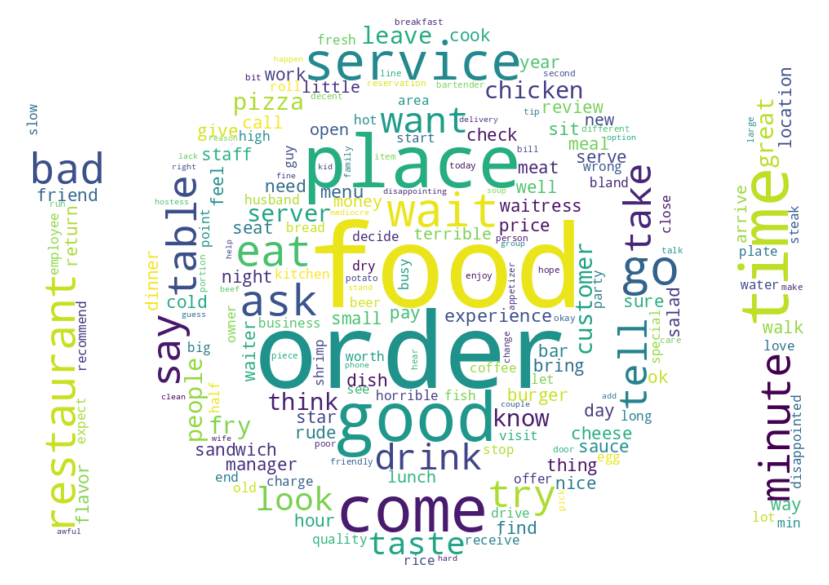

In [61]:
plot_wordcloud(" ".join(all_lemmas), name="wordcloud2")

## 3.4 Suppression des mots les plus fréquents <a class="anchor" id="most_frequents"></a> [⇪](#menu)

In [62]:
lemmas_freq = Counter(all_lemmas)
common_lemmas = lemmas_freq.most_common(100)
print (common_lemmas)

[('food', 8900), ('order', 7998), ('place', 5657), ('good', 4886), ('time', 4756), ('come', 4520), ('service', 4202), ('go', 3672), ('wait', 3263), ('like', 3255), ('get', 3200), ('ask', 2861), ('restaurant', 2817), ('eat', 2739), ('minute', 2661), ('bad', 2620), ('say', 2533), ('table', 2501), ('tell', 2326), ('try', 2214), ('take', 2151), ('want', 2093), ('drink', 2016), ('taste', 1972), ('look', 1927), ('chicken', 1820), ('leave', 1768), ('know', 1754), ('pizza', 1741), ('great', 1705), ('people', 1649), ('fry', 1637), ('customer', 1608), ('think', 1606), ('server', 1603), ('experience', 1559), ('sit', 1495), ('menu', 1457), ('meal', 1398), ('waitress', 1360), ('hour', 1343), ('staff', 1315), ('manager', 1305), ('price', 1295), ('well', 1294), ('give', 1290), ('cheese', 1282), ('serve', 1279), ('bar', 1270), ('thing', 1226), ('star', 1216), ('sauce', 1201), ('salad', 1189), ('review', 1161), ('need', 1139), ('way', 1135), ('nice', 1111), ('burger', 1107), ('walk', 1106), ('pay', 110

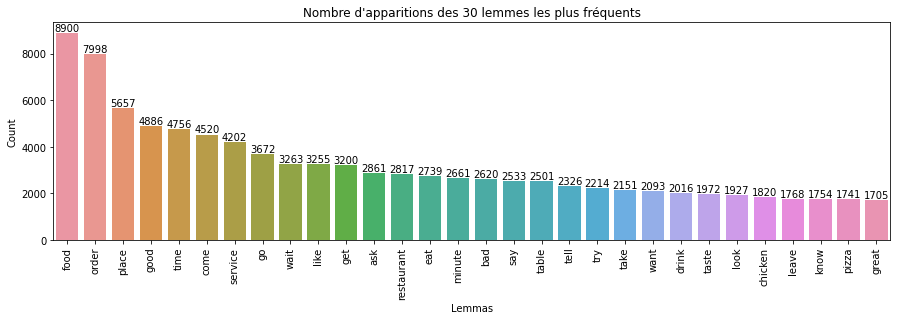

In [63]:
select = pd.DataFrame(common_lemmas[:30], columns=['lemmas','count'])
plot_bars(select, title="Nombre d'apparitions des 30 lemmes les plus fréquents", x='lemmas', y='count', show_values=True, y_label="Count", x_label="Lemmas")

>#### Les mots les plus fréquents sont des mots peu informatifs car présent dans la plupart des textes...
> Par exemple les lemmes `Food` ou `order` font plus de 6000 aparitions sur un jeu de données d'environ 10000 textes.

In [64]:
drop_lemmas = [x[0] for x in lemmas_freq.most_common(100)]
#drop_lemmas.extend(['come', 'go', 'tell', 'say', 'get', 'ask', 'want', 'try', 'look', 'take', 'find', 'let', 'guy', 'arrive', 'think'])

#### Visualisons le jeu de données après ce nettoyage plus complet

---
>#### `TODO`  done ✅ | todo ❌ |
> - ✅ Suppression les lemmes les plus fréquents
<br><u>*(action: fait avec la fonction `filter_extremes` du Dictionnaire un peu plus bas, au lieu du code ci-dessus)*</u>
> - ✅ Suppression des lemmes les moins fréquents
<br><u>*(action: fait avec la fonction `filter_extremes` du Dictionnaire un peu plus bas, au lieu du code ci-dessus)*</u>

## 3.5 Création du Dictionnaire <a class="anchor" id="dict"></a> [⇪](#menu)

Pour les modèles que nous allons essayer, il nous faut un **Dictionnaire** et un **Corpus**.
- Le Dictionnaire permet d'associer un ID unique à chaque token.
- Le `Corpus - Bag Of Word` contient une liste (un pour chaque document) de *term vectors* qui indiquent la fréquence de chaque mot du *vocabulaire*.
- Le `Corpus - TF-IDF` est une version *normalisée* du précédent pour éviter que des mots sans importance mais fréquents prennent trop d'importance.

In [65]:
from gensim.corpora.dictionary import Dictionary

In [66]:
dictionary = Dictionary(data_bad_reviews['lemmas'])

In [67]:
print(str(dictionary.token2id)[:1000], "... }")

{'afternoon': 0, 'app': 1, 'bill': 2, 'burger': 3, 'cig': 4, 'come': 5, 'cost': 6, 'counter': 7, 'delay': 8, 'delicious': 9, 'disappointed': 10, 'discount': 11, 'drink': 12, 'eat': 13, 'effective': 14, 'etc': 15, 'food': 16, 'frame': 17, 'fry': 18, 'go': 19, 'good': 20, 'hold': 21, 'hour': 22, 'look': 23, 'lunch': 24, 'manager': 25, 'mean': 26, 'medium': 27, 'menu': 28, 'minute': 29, 'multiple': 30, 'nice': 31, 'one': 32, 'option': 33, 'order': 34, 'pack': 35, 'party': 36, 'patient': 37, 'pickle': 38, 'plenty': 39, 'point': 40, 'rare': 41, 'reasonable': 42, 'return': 43, 'right': 44, 'ring': 45, 'round': 46, 'salad': 47, 'seat': 48, 'shack': 49, 'shake': 50, 'side': 51, 'slaw': 52, 'smell': 53, 'smoke': 54, 'standard': 55, 'start': 56, 'starve': 57, 'suppose': 58, 'take': 59, 'tell': 60, 'time': 61, 'vary': 62, 'wait': 63, 'waiter': 64, 'weird': 65, 'wonder': 66, 'yummy': 67, 'cold': 68, 'place': 69, 'seating': 70, 'service': 71, 'slow': 72, 'try': 73, 'ask': 74, 'clientele': 75, 'disa

In [68]:
len(dictionary)

13696

#### Supprimons les mots les plus fréquents et les moins fréquents
- On supprime les mots qui apparaissent dans moins de 5 documents
- On supprime les mots qui apparaissent dans plus de 50% des documents

In [69]:
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=None)

In [70]:
len(dictionary)

4258

#### Récupérons la Fréquence de chaque lemme pour afficher à nouveau le WordCloud

In [71]:
dico_df = pd.DataFrame(dictionary.items(), columns=['index', 'key']).set_index('index')

In [72]:
values = [[x[0], x[1]] for x in dictionary.cfs.items()]

In [73]:
count_df = pd.DataFrame(values, columns=['index','count']).set_index('index').sort_values('index')

In [74]:
TF = count_df.merge(dico_df, on='index', how='left').set_index('key')

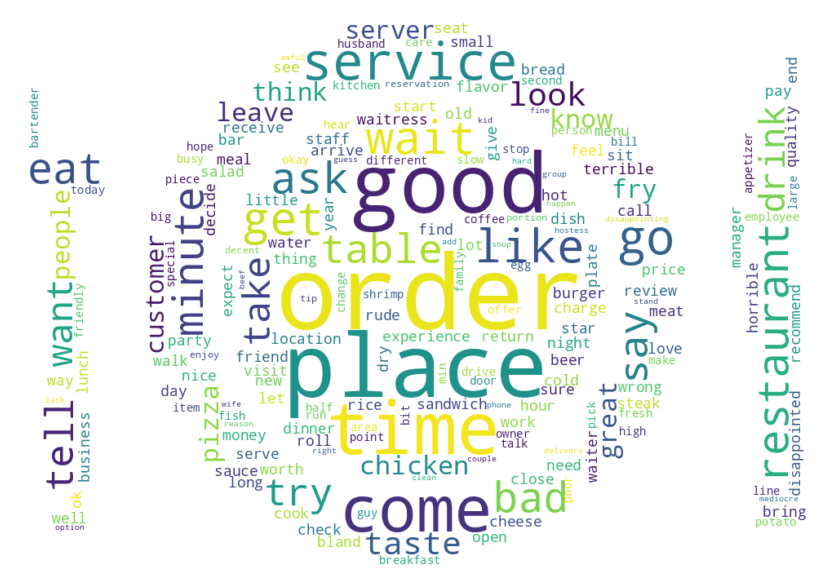

In [75]:
plot_wordcloud(TF.to_dict()['count'], from_frequency=True, name="wordcloud3")

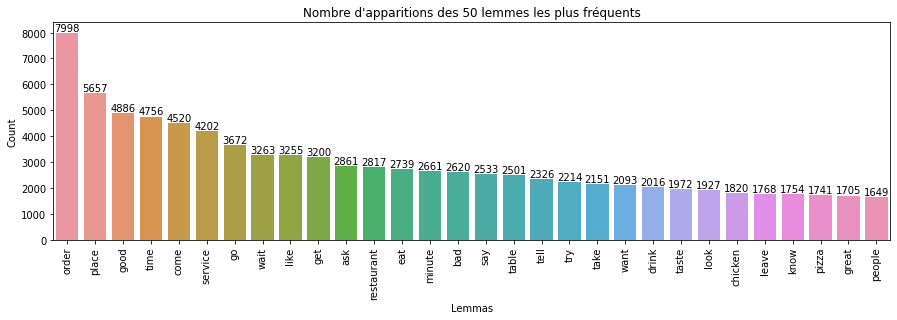

In [76]:
plot_bars(TF.sort_values('count', ascending=False)[:30].T, title="Nombre d'apparitions des 50 lemmes les plus fréquents", show_values=True, y_label="Count", x_label="Lemmas")

## 3.6 Création du Corpus Bag-Of-Words <a class="anchor" id="corpus_bow"></a> [⇪](#menu)

Le `Corpus - Bag Of Word` contient une liste (un pour chaque document) de *term vectors* qui indiquent la fréquence de chaque mot du *vocabulaire*.

In [77]:
corpus_bow = [dictionary.doc2bow(doc) for doc in data_bad_reviews['lemmas']]

## 3.7 Création du Corpus TF-IDF <a class="anchor" id="corpus_tfidf"></a> [⇪](#menu)
Le `Corpus - TF-IDF` est une version *normalisée* du Bag-Of-Words pour éviter que des mots sans importance mais fréquents prennent trop d'importance.

In [78]:
from gensim.models import TfidfModel

In [79]:
tfidf = TfidfModel(corpus_bow) # on a pas besoin de mettre les min_df et max_df ici car on a déjà appliqué un filter_extremes sur le Dictionnary
corpus_tfidf = tfidf[corpus_bow]

## 3.8 Création d'un Corpus Word2Vec <a class="anchor" id="corpus_word2vec"></a> [⇪](#menu)
Le `Corpus - Word2vec` associe un vecteur à chaque mot du *vocabulaire* au lieu d'une valeur de fréquence (normalisée ou non). Cett particularité permet de retrouver plus facilement des mots similaires *( Homme --> Chercheur | Femme --> ? --> Chercheuse)*

> ⚠️ Finalement je ne l'ai pas utilisé, donc je desactive les lignes de code ci-dessous

In [80]:
from gensim.models import Word2Vec

In [81]:
w2v_model = Word2Vec(data_bad_reviews['lemmas'], vector_size=500, min_count=5, sg=1)

---
---
# 4. Topic Modelling avec LDA<a class="anchor" id="lda_topic_modelling"></a> [⇪](#menu)

## 4.1 Latent Dirichlet Allocation *(LDA)* <a class="anchor" id="lda"></a> [⇪](#menu)

C'est une méthode non-supervisée générative vraiment efficace qui se base sur les hypothèses suivantes :
- Chaque document du corpus est un ensemble de mots sans ordre (bag-of-words)
- Chaque document *m* aborde un certain nombre de thèmes dans différentes proportions qui lui sont propres *p(θm)*
- Chaque mot possède une distribution associée à chaque thème *p(ϕk)*. On peut ainsi représenter chaque thème par une probabilité sur chaque mot.
- *z_n* représente le thème du mot *w_n*

> ⚠️ "In fact, Blei (who developed LDA), points out in the introduction of the paper of 2003 (entitled "Latent Dirichlet Allocation") that LDA addresses the shortcomings of the TF-IDF model and leaves this approach behind. LSA is compeltely algebraic and generally (but not necessarily) uses a TF-IDF matrix, while LDA is a probabilistic model that tries to estimate probability distributions for topics in documents and words in topics. The weighting of TF-IDF is not necessary for this."
>
> ⚠️ Le modèle **TF-IDF peut améliorer les résultats d'un LDA** dans le cas d'un **nombre extrêmement important de documents**. Mais dans l'ensemble, le **Bag-Of-Words est plus approprié** pour le modèle LDA.

#### Regardons ce qui donne un modèle LDA sur 10 topics

In [82]:
from gensim.models import LdaMulticore, CoherenceModel

In [83]:
lda_model = LdaMulticore(corpus=corpus_bow, id2word=dictionary, iterations=50, num_topics=10, passes=10, random_state=random_seed)

In [84]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus_bow, dictionary)
pyLDAvis.display(lda_display)

>#### On voit assez clairement que le nombre de cluster n'est pas idéal... ils sont très proches les uns des autres, ils se chevauchent.

## 4.2 Recheche du nombre optimal de sujets <a class="anchor" id="lda_coherence"></a> [⇪](#menu)

Les algorithmes de topic modelling reposent sur les mathématiques et les statistiques, mais les sujets mathématiquement optimaux ne sont pas nécessairement "bons" d'un point de vue humain et peuvent être des sujets trompeurs et dénués de sens.

L'évaluation des sujets est donc habituellement complétée par des évaluations humaines telles que la lecture des mots les plus importants de chaque sujet et la visualisation des sujets liés à chaque document *(word-cloud utilisés plus haut)*. Malheureusement, cette tâche exige souvent des connaissances préalables sur le domaine du jeu de données et peut nécessiter l'avis de spécialistes. Et même si l'on dispose d'un tel spécialiste, une telle vérification peut prendre beaucoup de temps et s'avérer impraticable pour de très grands ensembles de données contenant des milliers de sujets.

#### Score de Cohérence

Il convient donc d'utiliser une métrique capable de vérifier **automatiquement** que les mots groupés ensemble ont bel et bien un thème commun. C'est ce que font les métriques de **mesure de cohérence** des sujets qui tentent de représenter la qualité de la perception humaine des sujets sous la forme d'un nombre unique en mesurant le degré de similarité sémantique entre les mots ayant obtenu un score élevé dans chaque thème *(c.a.d. la distance relative entre les mots d'un même sujet)*.

Un point important des mesures de cohérence des sujets est qu'**elles dépendent non seulement du sujet lui-même mais aussi de l'ensemble de données utilisé comme référence**...

<img src="medias/coherence_score.png" width="400">

Il existe plusieurs modèles pour calculer un score de coéherence *(C_v, C_p, C_uci, C_umass, C_npmi, C_a, ...)*, mais nous allons utiliser le modèle C_umass car il est souvent recommandé *(mais aussi parcque c'est celui qui m'a donné les résultats les plus rapides lors de mes tests...)*.

#### C_umass
- la mesure de cohérence retournée par le modèle C_umass est négative,
- plus le score est grand et plus la mesure de cohérence indique que le sujet est compréhensible par les humains.


In [85]:
def plot_coherence(scores, max_topics, min_topics=1):
    plt.figure(figsize=(10, 4))
    plt.plot(range(min_topics,max_topics), scores)
    plt.gca().xaxis.grid(True)
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.xticks(range(min_topics,max_topics))
    plt.show()

#### ~~Calculons les courbes de cohérence avec le corpus TF-IDF~~
> ⚠️ Il est préférable d'utiliser le Corpus BoW pour un LDA *(car le Corpus TF-IDF associé au LDA augmente le poids des mots rares)*<br>
> J'ai donc désactivé les cellules ci-dessous, mais avant désactivation les résultats étaient effectivement moins performants qu'avec le Corpus Bow juste après.

#### Calculons les courbes de cohérence avec le corpus Bag-Of-Words

In [86]:
score = []
max_topics = 15
for i in tqdm(range(1,max_topics,1)):
    lda_model = LdaMulticore(corpus=corpus_bow, id2word=dictionary, iterations=10, num_topics=i, passes=10, random_state=random_seed)
    cm = CoherenceModel(model=lda_model, corpus=corpus_bow, dictionary=dictionary, coherence='u_mass')
    score.append(cm.get_coherence())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [03:52<00:00, 16.58s/it]


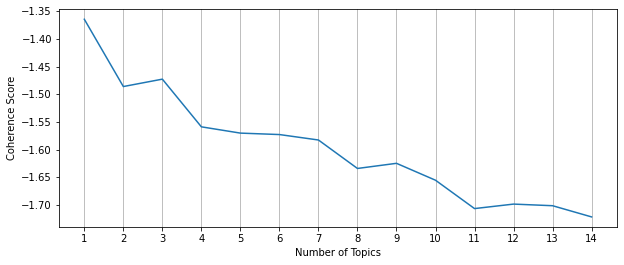

In [87]:
plot_coherence(score, max_topics)

#### Calculons le score c_v

In [88]:
score = []
max_topics = 15
for i in tqdm(range(1,max_topics,1)):
    lda_model = LdaMulticore(corpus=corpus_bow, id2word=dictionary, iterations=10, num_topics=i, passes=10, random_state=random_seed)
    cm = CoherenceModel(model=lda_model, texts = data_bad_reviews['lemmas'], dictionary=dictionary, coherence='c_v')
    score.append(cm.get_coherence())

 29%|██████████████████████████████████████████████████████▎                                                                                                                                       | 4/14 [01:00<02:38, 15.85s/it]/home/valkea/Dev/OpenClassrooms/Projets_AI/P6/venvP6/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/valkea/Dev/OpenClassrooms/Projets_AI/P6/venvP6/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/valkea/Dev/OpenClassrooms/Projets_AI/P6/venvP6/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/ho

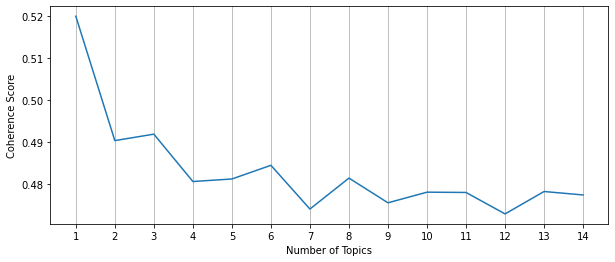

In [89]:
plot_coherence(score, max_topics)

#### Conclusion
> En regardons l'évolution du score de cohérence avec le Corpus BoW (qui est plus dapté pour un LDA), on constate que:
> - le score de cohérence `c_v` comme le score `u_mass` recommandent d'utiliser **3 sujets** *(si l'on met de coté les 1 et 2 qui ne sont pas très utiles)*
> - le **corpus Bow** est plus adapé que le corpus TF-IDF avec le LDA.
> - le coherence c_v score est donc **> 0.49**

---
---
# 5. Topic Modelling avec NMF<a class="anchor" id="nmf_topic_modelling"></a> [⇪](#menu)

## 5.1 Negative Matrix Factorisation *(NMF)* <a class="anchor" id="nmf"></a> [⇪](#menu)

C'est une méthode non supervisée, qui décompose *(ou factorise)* des vecteurs de haute dimension en une représentation de plus faible dimension. Ces vecteurs *(de haute dimension ou de dimension inférieure)* sont non négatifs, ce qui signifie également que leurs coefficients sont non négatifs. En utilisant la matrice originale *(A)*, la NMF donnera deux matrices *(W et H)*. 

On peut intérpréter ces matrices comme suit:
- `A` **représente les articles par mots**,
- `W` **représente les articles par sujets** (c.a.d. les sujets trouvés).
- `H` **représente les sujets par mots.** (c.a.d. les coefficients des sujets trouvés).

In [90]:
from gensim.models import Nmf

In [91]:
import warnings
warnings.filterwarnings("ignore", message="Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.")

In [92]:
# Train the model on the corpus.
nmf = Nmf(corpus_tfidf, num_topics=10)

## 5.2 Recheche du nombre optimal de sujets <a class="anchor" id="nmf_coherence"></a> [⇪](#menu)

#### Avec le corpus Bag-Of-Words

In [93]:
score = []
min_topics = 3
max_topics = 15
for i in tqdm(range(min_topics,max_topics,1)):
    nmf_model = Nmf(corpus=corpus_bow, num_topics=i, id2word=dictionary, passes=10, random_state=random_seed)
    cm = CoherenceModel(model=nmf_model, corpus=corpus_bow, dictionary=dictionary, coherence='u_mass')
    score.append(cm.get_coherence())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [01:55<00:00,  9.60s/it]


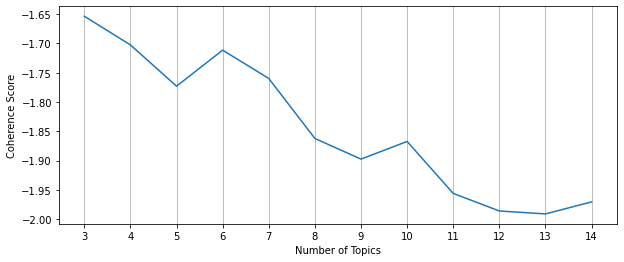

In [94]:
plot_coherence(score, max_topics, min_topics)

In [95]:
score = []
min_topics = 3
max_topics = 15
for i in tqdm(range(min_topics,max_topics,1)):
    nmf_model = Nmf(corpus=corpus_bow, num_topics=i, id2word=dictionary, passes=10, random_state=random_seed)
    cm = CoherenceModel(model=nmf_model, texts = data_bad_reviews['lemmas'], dictionary=dictionary, coherence='c_v')
    score.append(cm.get_coherence())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [02:23<00:00, 11.96s/it]


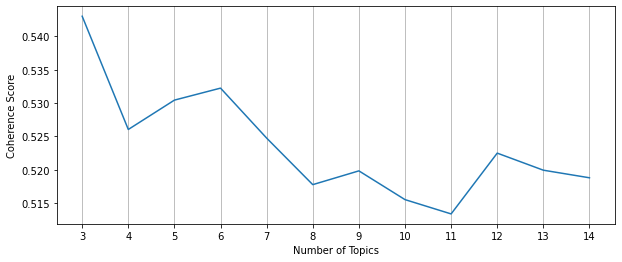

In [96]:
plot_coherence(score, max_topics, min_topics)

#### Avec le corpus TF-IDF

In [97]:
score = []
min_topics = 3
max_topics = 15
for i in tqdm(range(min_topics,max_topics,1)):
    nmf_model = Nmf(corpus=corpus_tfidf, num_topics=i, id2word=dictionary, passes=10, random_state=random_seed)
    #nmf_model = Nmf(corpus=corpus_tfidf, num_topics=i, passes=10, random_state=random_seed)
    cm = CoherenceModel(model=nmf_model, corpus=corpus_tfidf, dictionary=dictionary, coherence='u_mass')
    score.append(cm.get_coherence())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [05:10<00:00, 25.87s/it]


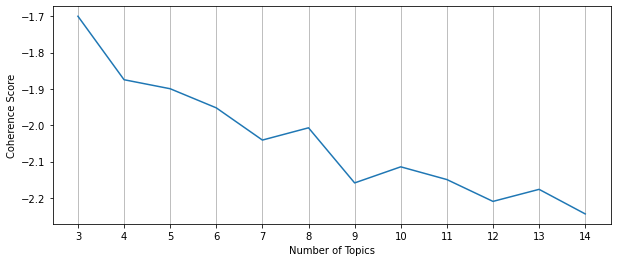

In [98]:
plot_coherence(score, max_topics, min_topics)

In [99]:
score = []
min_topics = 3
max_topics = 15
for i in tqdm(range(min_topics, max_topics,1)):
    nmf_model = Nmf(corpus=corpus_tfidf, num_topics=i, id2word=dictionary, passes=10, random_state=random_seed)
    cm = CoherenceModel(model=nmf_model, texts = data_bad_reviews['lemmas'], dictionary=dictionary, coherence='c_v')
    score.append(cm.get_coherence())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [05:57<00:00, 29.76s/it]


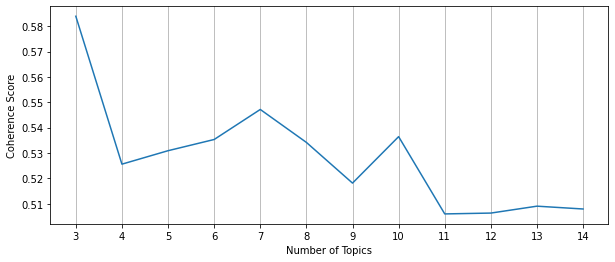

In [100]:
plot_coherence(score, max_topics, min_topics)

#### Conclusion
> En regardons l'évolution des scores de cohérence avec les Corpus BoW et TF-IDF, on constate que:
> - le score de cohérence `c_v` qui est plus précis que le score `u_mass` recommande d'utiliser **6 ou 7 sujets**.
> - le **corpus TF-IDF** semble être celui qui fonctionne le mieux sur ce jeu de données avec le NMF
> - le coherence score est donc **> 0.55**

#### (bonus) Essayons d'obtenir la même chose avec sklearn

In [101]:
from sklearn.decomposition import NMF
from itertools import combinations

In [102]:
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.wv.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

In [103]:
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

In [104]:
all_xxx = [" ".join(x) for x in data_bad_reviews.lemmas]
len(all_xxx)

9993

In [105]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [106]:
tfidf_vectorizer = TfidfVectorizer(use_idf=True, min_df=5, max_df=0.5)
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(all_xxx)
display(tfidf_vectorizer.get_feature_names_out())
print(tfidf_vectorizer_vectors.shape)

array(['abandon', 'ability', 'able', ..., 'zero', 'zone', 'zucchini'],
      dtype=object)

(9993, 4242)


In [107]:
kmin, kmax = 3, 15
topic_models = []

for k in tqdm(range(kmin,kmax)):
    #print("Applying NMF for k=%d ..." % k )
    model = NMF( init="nndsvd", n_components=k, random_state=random_seed ) 
    W = model.fit_transform( tfidf_vectorizer_vectors )
    H = model.components_
    topic_models.append( (k,W,H) )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:14<00:00,  1.22s/it]


In [108]:
terms =  list(tfidf_vectorizer.get_feature_names_out())
k_values = []
coherences = []
for (k,W,H) in tqdm(topic_models):
    
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
        
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    
    # print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 81.07it/s]


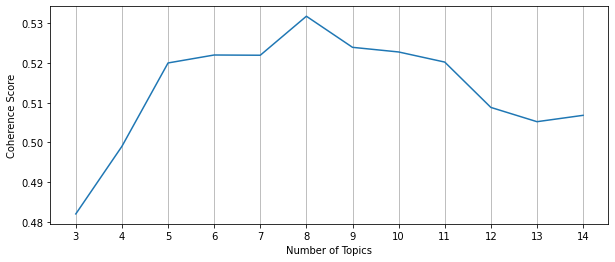

In [109]:
plot_coherence(coherences, kmax, kmin)

---
---
# 6. Modèle final<a class="anchor" id="final_model"></a> [⇪](#menu)

## 6.1 Entrainement & interprétation du meilleur modèle LDA <a class="anchor" id="final_model_lda"></a> [⇪](#menu)

Nous avons vu avec les courbes de cohérences que le meilleur choix pour le LDA semble être de chercher **3 sujets** en utilisant le **corpus Bag-Of-Words**.

### Entrainons donc le modèle avec le nombre de sujets optimal

In [110]:
selected_num_topics = 3
selected_corpus= corpus_bow
lda_model = LdaMulticore(corpus=selected_corpus, num_topics=selected_num_topics, id2word=dictionary, iterations=100, passes=100, random_state=random_seed)

### Affichons les lemme utilisés pour définir les sujets et leur poids

In [111]:
lda_model.print_topics(-1)

[(0,
  '0.025*"order" + 0.017*"wait" + 0.017*"time" + 0.016*"service" + 0.015*"come" + 0.014*"minute" + 0.013*"ask" + 0.013*"place" + 0.012*"go" + 0.012*"say"'),
 (1,
  '0.026*"order" + 0.018*"pizza" + 0.014*"good" + 0.014*"fry" + 0.013*"like" + 0.013*"chicken" + 0.013*"cheese" + 0.012*"place" + 0.011*"burger" + 0.011*"get"'),
 (2,
  '0.021*"good" + 0.019*"place" + 0.011*"like" + 0.011*"restaurant" + 0.011*"service" + 0.009*"price" + 0.009*"taste" + 0.008*"order" + 0.008*"come" + 0.008*"great"')]

### Cherchons les textes qui collent le plus aux sujets pour nous aider à les interpréter

In [112]:
max_values = {}
max_index = {}
for i in range(len(corpus_bow)):
    row = dict(lda_model[corpus_bow][i])
    
    for j in range(selected_num_topics):
        if row.get(j, 0) > max_values.get(j, 0):
            max_values[j] = row.get(j, 0)
            max_index[j] = i
            
    if i > 500:
        break
        
print(max_values)
print(max_index)

{0: 0.990788, 1: 0.9829053, 2: 0.9888693}
{0: 261, 1: 268, 2: 280}


In [113]:
explore_id = 64  # (0) 43 261 750 6087 (1) 92 268 944 5780 (2) 64 280 746 2843
display(lda_model[corpus_bow][explore_id])
display("-------------", data_bad_reviews['text'][explore_id])
display("-------------", " | ".join(data_bad_reviews['lemmas'][explore_id]))

[(0, 0.014408883), (1, 0.016020782), (2, 0.96957034)]

'-------------'

"One of the worst Italian restaurants I have ever been to in terms of the food.  Ambiance is nice, service was good, but food was awful.  Bland. Pasta was overcooked to the point of mush.  Truffle gnocchi had barely any truffle flavor and, again bland.  A waste of $100 and what was supposed to be a special night out.  There are so many great places in Philly so don't go here."

'-------------'

'bad | italian | restaurant | term | food | ambiance | nice | service | good | food | awful | pasta | overcook | point | mush | truffle | gnocchi | truffle | flavor | bland | waste | suppose | special | night | great | place'

>#### On peut supposer que :
> - le `sujet 0` concerne `la qualité du service`.
> - le `sujet 1` concerne `la qualité des produits proposés`.
> - le `sujet 2` concerne `une déception dans un établissement apprécié` ou `la qualité de la prépatation ou conservation`

> ⚠️ Les sujets ne sont pas faciles à identifier, même en explorant les textes les mieux placés dans ces topics.

## Visualisation du LDA <a class="anchor" id="final_model_lda_vis"></a> [⇪](#menu)

### Visualisons les sujets avec pyLDAvis

Le graphique `pyLDAvis` ci-dessus représente les sujets sous forme de cercles, réduits en dimmensionalité à l'aide d'une PCA.

Dans l'idéal, les cercles ne doivent pas se chevaucher et même maximiser la distance entre eux car les sujets les plus proches les uns des autres sont aussi les sujets les plus liés (donc les sujets potentiellement redondants). Lorsque l'on clique sur un cercle, les différents lemmes sont affichés à droite avec leurs fréquences dans le corpus en bleu et leurs fréquences estimées dans le sujet sélectionné en rouge.

In [114]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus_bow, dictionary)
pyLDAvis.display(lda_display)

>#### On retrouve les idées sous-jacentes des topics identifiés, mais surtout avec ce graphique, on peut voir que les topics sont correctement séparés et de taille raisonnablement équivalente.

### Visualisons les sujets avec t-SNE

In [115]:
from sklearn.manifold import TSNE
def plot_TSNE_bow(X_ref, y_ref, title='t-SNE'):
    
    X_embedded = TSNE(n_components=2).fit_transform(X_ref)
    dataV=pd.DataFrame(X_embedded, columns=["D1","D2"])
    #dataV['cluster']=model_ref.labels_.tolist()
    dataV['cluster']=y_ref
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(dataV['D1'],dataV['D2'], c=dataV['cluster'], s=50, cmap=cmap_ref, marker='+')
    plt.colorbar(scatter)
    ax.set_title(title)
    ax.set_xlabel('Dimention 1')
    ax.set_ylabel('Dimention 2')
    plt.show()

In [116]:
pd.DataFrame(corpus_bow).shape

(9993, 138)

#### Retrouver l'ID du sujet principal de chaque review

In [117]:
def get_top_id(row):
    max_id = None
    max_va = 0
    for topics in row:
        if topics == None:
            continue
        #print(topics)
        cur_id = topics[0]
        cur_va = topics[1]
        if cur_va > max_va:
            max_va = cur_va
            max_id = cur_id
            
    if math.isclose(max_va, 0.33333, rel_tol=1e-1):
        return selected_num_topics # regular topics are affecter to ID O, 1, 2, ... and filtered reviews are affected to this extra group
    else:
        return max_id

In [118]:
input_pred = pd.DataFrame(lda_model[corpus_bow])
# input_pred.dropna(inplace=True)

In [119]:
main_topics = input_pred.apply(get_top_id, axis=1)

In [120]:
pd.DataFrame(main_topics).value_counts(dropna=False)

0    4768
2    2908
1    2287
3      30
dtype: int64

#### Récupérons la liste des sujets principaux

In [121]:
encoded_labels = np.array(main_topics.values.tolist(), dtype=np.int32)

#### Récupérons les bag of words dans un format exploitable par le t-SNE

In [122]:
bows = []
for i in range(len(corpus_bow)):
    select = pd.DataFrame(corpus_bow[i], columns=['index','count'])
    select.set_index('index', inplace=True)
    select = select.reindex(list(range(0,dico_df.shape[0])),fill_value=0)
    bow = [x[0] for x in select.values]
    bows.append(bow)
               
bows_df = pd.DataFrame(bows)

#### Appliquons le t-SNE

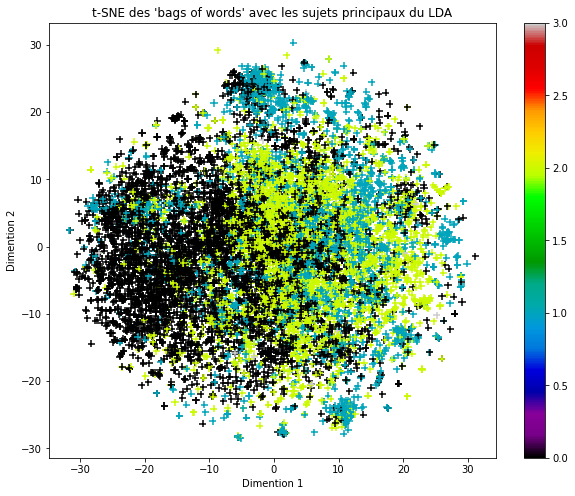

In [123]:
plot_TSNE_bow(bows, encoded_labels, title="t-SNE des 'bags of words' avec les sujets principaux du LDA")

## 6.2 Entrainement & interprétation du meilleur modèle NMF <a class="anchor" id="final_model_nmf"></a> [⇪](#menu)

Nous avons vu avec les courbes de cohérences que le meilleur choix pour le NMF semble être de chercher **4 sujets** en utilisant le **corpus Bag-Of-Words**.

### Entrainons donc le modèle avec le nombre de sujets optimal

In [137]:
selected_num_topics = 7
selected_corpus = corpus_tfidf
nmf_model = Nmf(corpus=selected_corpus, num_topics=selected_num_topics, id2word=dictionary, passes=100, random_state=random_seed)

### Affichons les lemme utilisés pour définir les sujets et leur poids

In [138]:
nmf_model.print_topics(-1)

[(0,
  '0.031*"order" + 0.031*"call" + 0.023*"delivery" + 0.019*"tell" + 0.018*"hour" + 0.017*"phone" + 0.014*"say" + 0.012*"time" + 0.011*"deliver" + 0.010*"pick"'),
 (1,
  '0.033*"table" + 0.019*"server" + 0.019*"seat" + 0.018*"wait" + 0.017*"sit" + 0.013*"reservation" + 0.012*"hostess" + 0.012*"hour" + 0.012*"party" + 0.011*"bar"'),
 (2,
  '0.009*"price" + 0.009*"place" + 0.008*"good" + 0.008*"great" + 0.007*"restaurant" + 0.006*"well" + 0.006*"quality" + 0.006*"eat" + 0.006*"menu" + 0.005*"breakfast"'),
 (3,
  '0.128*"pizza" + 0.020*"crust" + 0.016*"cheese" + 0.009*"topping" + 0.009*"slice" + 0.008*"sauce" + 0.008*"wing" + 0.007*"pepperoni" + 0.007*"dough" + 0.007*"hut"'),
 (4,
  '0.017*"chicken" + 0.017*"burger" + 0.016*"fry" + 0.010*"taste" + 0.009*"sauce" + 0.009*"cheese" + 0.008*"dry" + 0.008*"salad" + 0.008*"flavor" + 0.008*"rice"'),
 (5,
  '0.038*"minute" + 0.031*"drink" + 0.026*"waitress" + 0.024*"wait" + 0.023*"take" + 0.017*"ask" + 0.017*"come" + 0.015*"order" + 0.014*"bri

>#### On peut supposer que :
> - le `sujet 0` concerne `le temps de service / de livraison`.
> - le `sujet 1` concerne `le temps d'attente en salle`.
> - le `sujet 2` concerne `le rapport qualité / prix`
> - le `sujet 3` concerne `une déception dans un établissement apprécié`
> - le `sujet 4` concerne `la qualité des produits proposés`.
> - le `sujet 5` concerne `la qualité des entrées / cocktails`
> - le `sujet 6` concerne `le comportement du personnel`

> ⚠️ Les sujets ne sont pas faciles à identifier, même en explorant les textes les mieux placés dans ces topics.

### Cherchons les textes qui collent le plus aux sujets pour nous aider à les interpréter

In [155]:
max_values = {}
max_index = {}
for i in range(len(corpus_bow)):
    row = dict(nmf_model[corpus_bow][i])
    
    for j in range(selected_num_topics):
        if row.get(j, 0) > max_values.get(j, 0):
            max_values[j] = row.get(j, 0)
            max_index[j] = i
            
    if i > 100:
        break
        
print(max_values)
print(max_index)

{0: 0.851082827582954, 1: 0.7895752992900076, 4: 0.790946111091095, 5: 0.6305329374545089, 2: 0.8760546670772342, 6: 0.7236061759955519, 3: 0.9386938767900949}
{0: 10, 1: 83, 4: 74, 5: 20, 2: 7, 6: 19, 3: 38}


In [174]:
explore_id = 652  # 0: 1704 736 | 1: 2394 1497 743 | 2: 251 963 | 3: 2049 38 | 4: 170 74 | 5: 3808 841 | 6: 652
display(nmf_model[corpus_bow][explore_id])
display(data_bad_reviews['text'][explore_id])

[(6, 1.0)]

'Was not impressed with the customer service at all. They were not easy to work with and were very rude to us when we used them for an event. Would not recommend.'

## Visualisation du NMF <a class="anchor" id="final_model_nmf_vis"></a> [⇪](#menu)

### Visualisons les sujets avec t-SNE

#### Retrouver l'ID du sujet principal de chaque review

In [128]:
input_pred = pd.DataFrame(nmf_model[corpus_bow])
# input_pred.dropna(inplace=True)

In [129]:
main_topics = input_pred.apply(get_top_id, axis=1)

In [130]:
pd.DataFrame(main_topics).value_counts(dropna=False)

7    1833
1    1608
4    1453
2    1296
0    1109
5    1089
6     892
3     713
dtype: int64

#### Récupérons la liste des sujets principaux

In [131]:
encoded_labels = np.array(main_topics.values.tolist(), dtype=np.int32)

#### Récupérons les bag of words dans un format exploitable par le t-SNE

In [132]:
bows = []
for i in range(len(corpus_bow)):
    select = pd.DataFrame(corpus_bow[i], columns=['index','count'])
    select.set_index('index', inplace=True)
    select = select.reindex(list(range(0,dico_df.shape[0])),fill_value=0)
    bow = [x[0] for x in select.values]
    bows.append(bow)
               
bows_df = pd.DataFrame(bows)

#### Appliquons le t-SNE

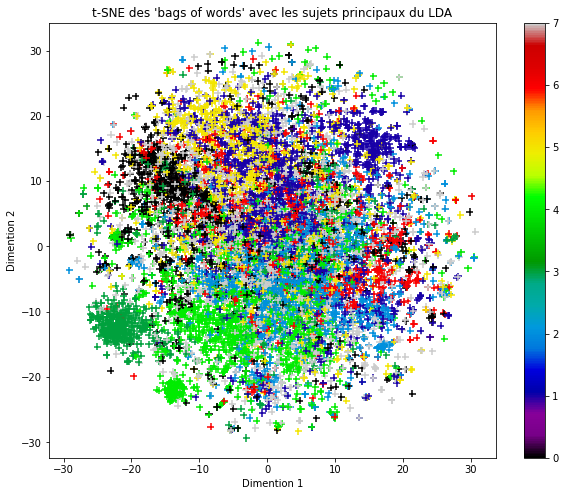

In [133]:
plot_TSNE_bow(bows, encoded_labels, title="t-SNE des 'bags of words' avec les sujets principaux du LDA")

## 6.3 Export du modèle sélectionné <a class="anchor" id="final_model_export"></a> [⇪](#menu)

>#### Au final, j'ai décidé d'utiliser **le modèle LDA**:
> - c'est celui qui me semble le plus cohérent d'un point de vue des topics proposés
> - il a un score de cohérence inférieur, mais proche malgré tout de celui du NMF
> - il est plus facile à visualiser à l'aide de pyLDAvis (il aurait fallu faire le NMF avec sklearn pour pouvoir faire la même chose, mais j'ai utilisé gensim...), ce qui est utile ici puisque l'on veut **montrer** nos résultats.

In [135]:
import joblib

topics = {
    0: "La qualité du service",
    1: "La qualité des produits proposés",
    2: "Une déception dans un établissement apprécié",
}

joblib.dump((dictionary, lda_model, topics), os.path.join("models", "lda.pipeline"))
joblib.dump((dictionary, lda_model, topics, corpus_bow), os.path.join("models", "lda_vis.pipeline"))

['models/lda_vis.pipeline']

#### Tests du pipeline pour l'export LDA

#### Tests du pipeline pour l'export NMF

---
---
# Pistes d'Amélioration

- Utiliser des Bigrams et Trigrams
- Supprimer les Hotels (certains établissement font Restaurant & Hotel)